# Analisi delle formanti

* Registrare un secondo circa di audio sostenendo una vocale
* Analizzarlo con Praat

## Analisi con Praat

- Sul "Sound" object selezionare "View & Edit"
- Posizionare il cursore a metà della forma d'onda e selezionare "Spectrogram > View Spectral Slice"
- Sullo spettro provare ad identificare le formanti F1 ed F2
- Verificare sullo spettrogramma la loro posizione (se non sono visualizzate scegliere "Formants > Show Formants"
- Estrarre il valore delle formanti con "Formants > Formant listing"




![image.png](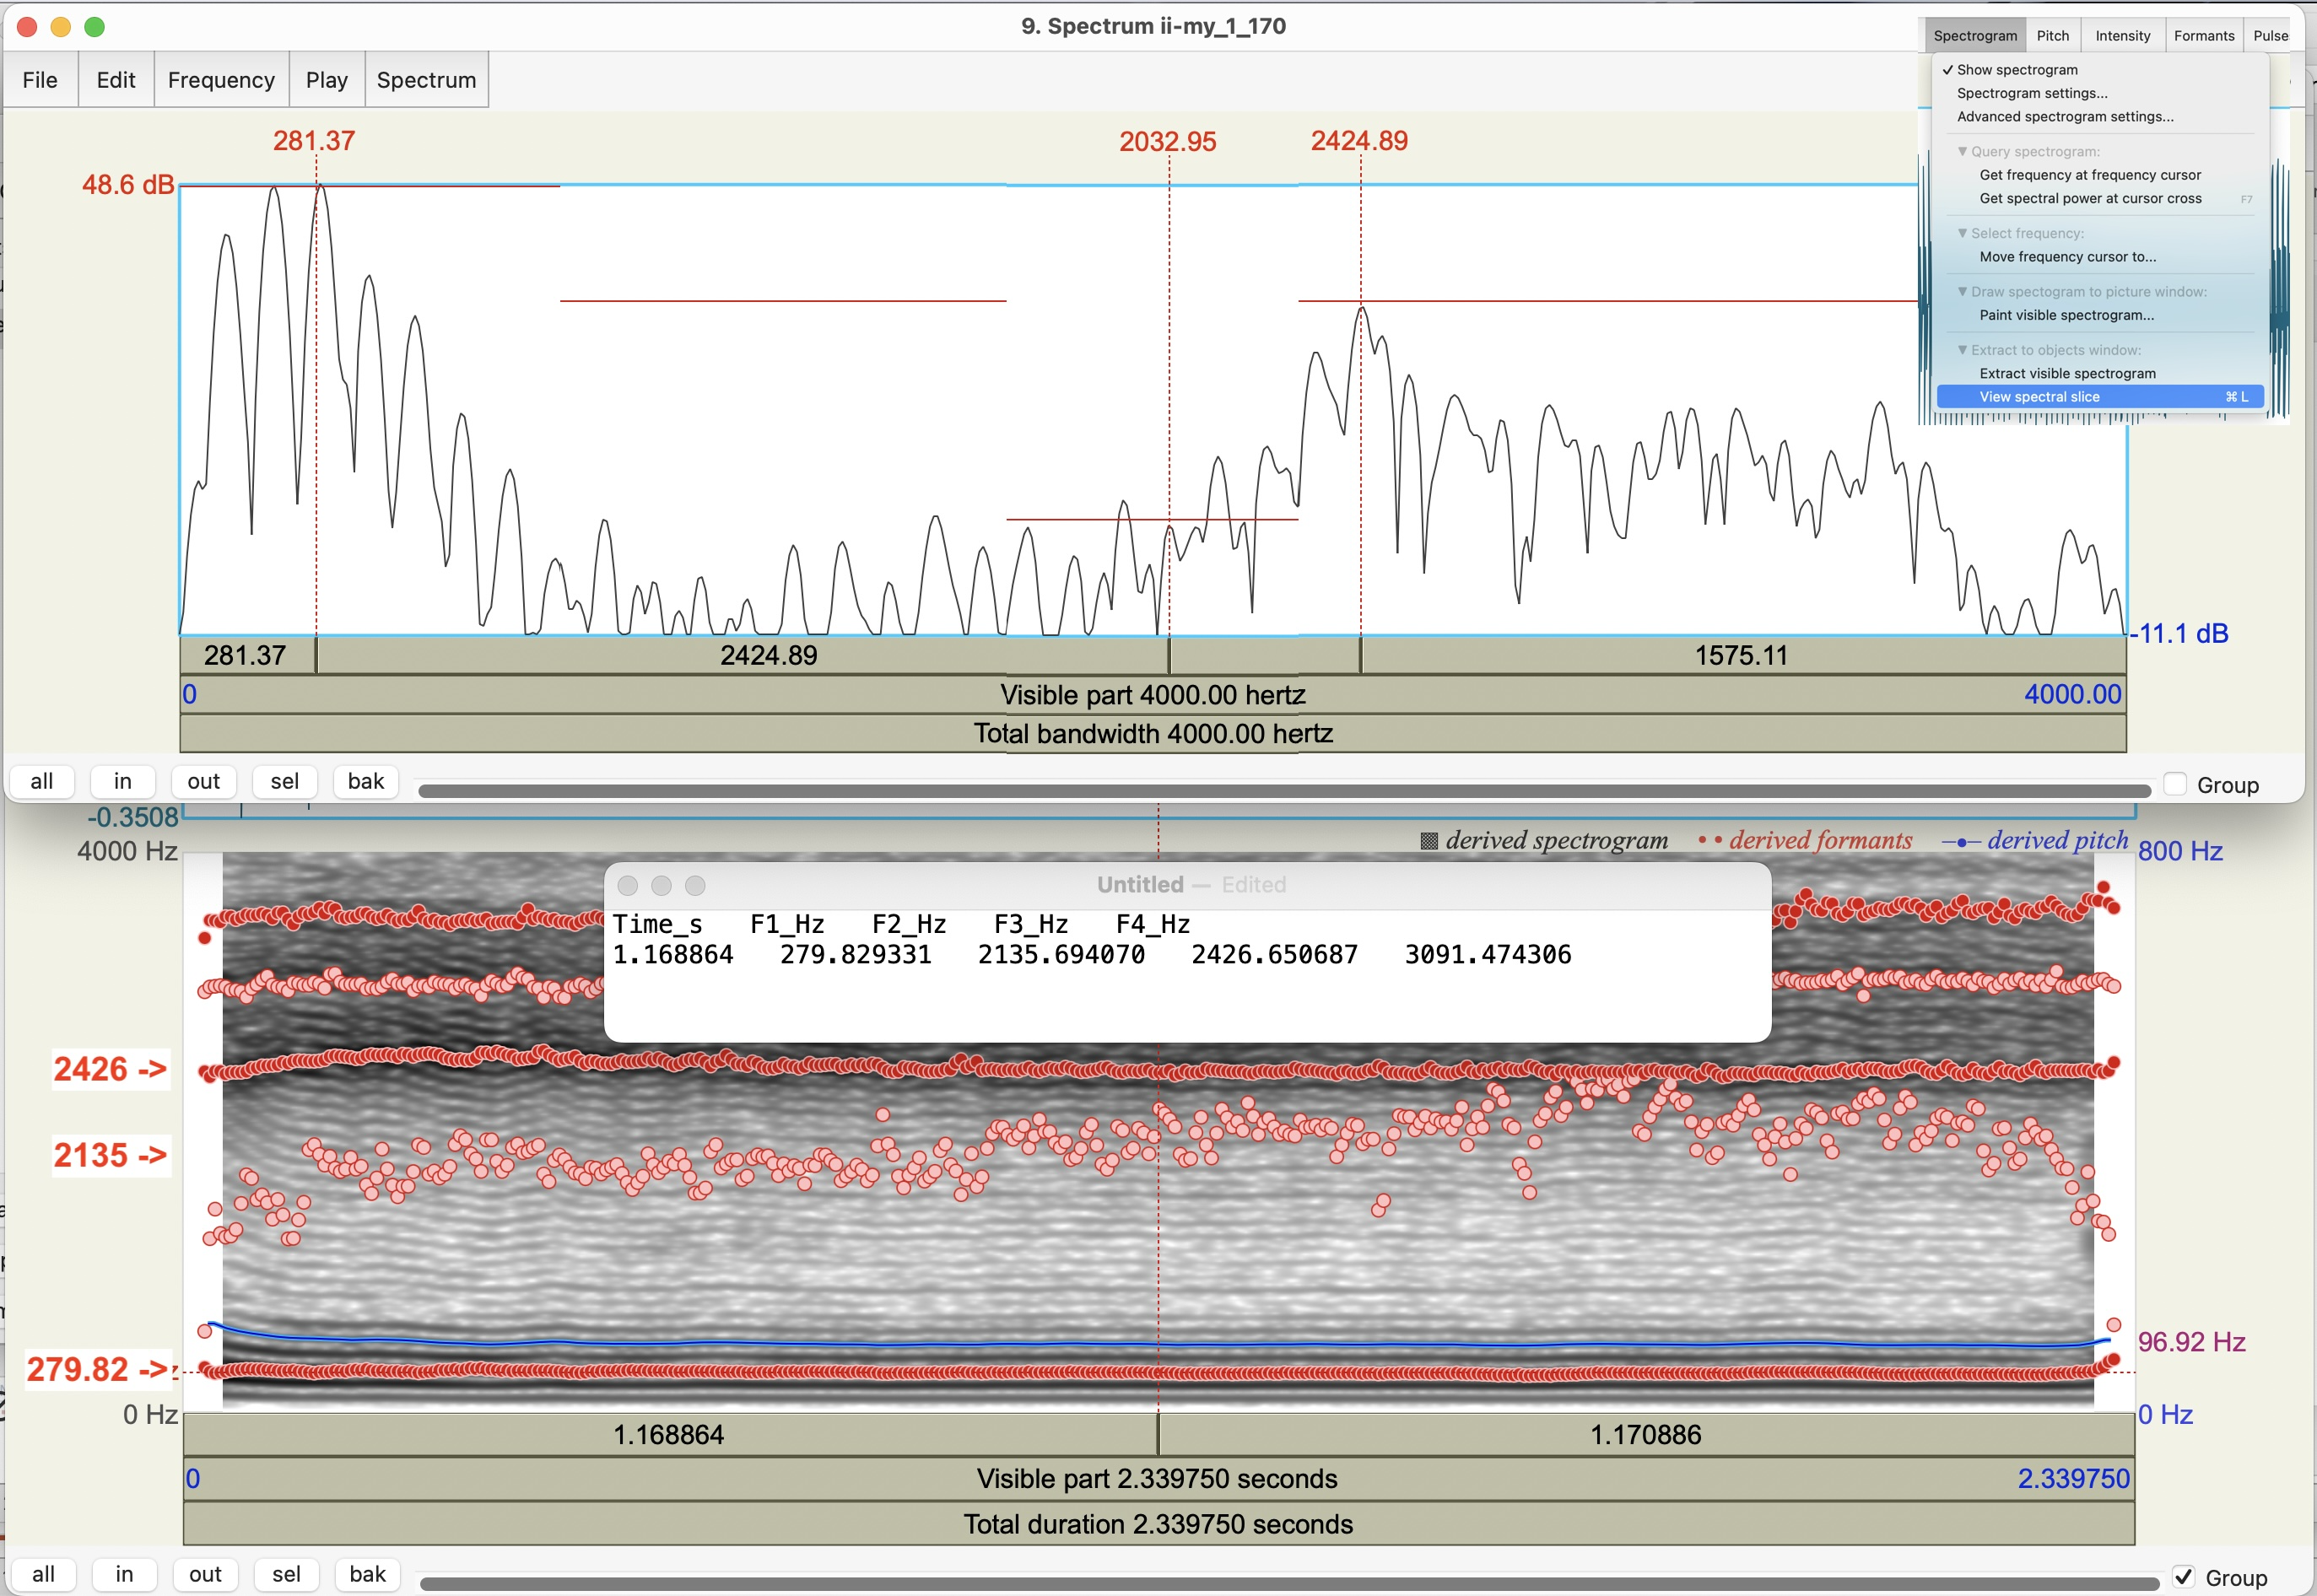mpkToS/widFVR7UWPPjxcN53I7hn+4Ve/24IUQzhhGGw/q/XnwGyRDWa+rvUBPMxiDVom92248//ujnBvwAgYvuiYEYs08dn5Alu0t3un+Pcv64fvGuT95kS3vwe/vtt//0009yy4sHvL7gk08+scdtt91mP80jBRozmxH0WgLVR7AlYWxBSChRZjaWprSht2m86ZllKsK8KvJYSKAZSgI/UerTKP8QV80ytQyXVYbxn/jJWpSEfCAN/2L8nMd/diePfcsH5108v79/Apny2cnCPz50EZo/IzHy2fkn8smHfXz2CTTLuZL8w2YnD6ZMoM9UhPQMxjB5MmvIuX9mYf0Dog1i5PIZNJo/+ZgMIMuwfBYgy7B8FiDLsHwWIMuwfBYgy7B8FiDLsHwWIMuwfBYgy7B8FiDLsHwWIMuwfBYgy7B8FiDLsHwWIMuwfBYgy7B8FiDLsHwWIMuwfBYgy7B8FiDLsHwWIMvwevHxr9ZccR7/Sx0h+vSzZYyzcK9+2C/L5+Feea+f+p8pbeGTr+szYJ9eJcJr/lXqf/vtt19//dWPA1y5cuXy5cs///wzwY8DqNHfcccdKviaJVp+MSBy+uxOlhX6/wdkAsoZJO1dyAAAAABJRU5ErkJggg==)

## Analisi con il notebook

- Caricare il file audio in Colab
- Definire la variabile `filename` (qui, nel prossimo blocco) con il path al file
- Eseguire il notebook e analizzarne i risultati

- Riportare il valore delle formanti F1 ed F2 sul GSheet https://bit.ly/ead26-gsheet-formants

  * F1 nella prima colonna
  * F2 nella colonna corrispondente alla vocale

In [ ]:
# Change with filename of your file
filename = './ii-my.wav'

In [1]:
# deps install
!pip install -q librosa
!pip install praat-parselmouth


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 107.2 MB/s eta 0:00:00


In [8]:
# imports
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import parselmouth
import scipy

plt.rcParams['font.size'] = 16

In [13]:
# @title
import numpy as np

def dft(x, Fs, N=None):
  L = len(x)
  N = L if N is None else N
  X = np.fft.rfft(x, N)
  X_ = np.abs(X) / (L/2)
  freq = np.fft.rfftfreq(N, d=1./Fs)
  # X_ = X_[:N//2+1]
  # freq = freq[:N//2+1]
  # X_dBFS = 20*np.log10(X_)
  return X_, freq


def normalize(x):
  return x / np.max(np.abs(x))

import matplotlib.pyplot as plt


def plot_vs_time(w, t, xlim=None, ylim=[-1, +1], fig=None, fmt='-'):

    fig, ax = plt.subplots(figsize=(12,3)) if fig is None else fig
    ax.plot(t,w,fmt)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(xlim) if xlim is not None else plt.xlim(t[0],t[-1])
    ax.set_ylim(ylim) if ylim is not None else None
    fig.tight_layout()
    ax.grid(visible=True)

import numpy as np
import matplotlib.pyplot as plt

# plot frequency spectrum
def plot_vs_freq(X, f, Fs, type="linear", xlim=None, ylim=None, fig=None, zp=False, fmt="-"):

  fig, ax = plt.subplots(figsize=(6,3)) if fig is None else fig
  xlim = [np.min(f), np.max(f)] if xlim is None else xlim

  if type == "linear":
    ax.set_ylabel('Magnitude')
    ylim = [0, 1.2] if ylim is None else ylim
    X = X
  elif type == "log":
    ax.set_ylabel('Power (dBFS)')
    ylim = [-60, +6] if ylim is None else ylim
    X = 10*np.log10(X**2)

  ax.plot(f, X, fmt)
  ax.set_xlabel('Frequency (Hz)')

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  plt.grid(visible=True);
  plt.tight_layout()

# plot_vs_freq(x, Fs, N)
# plot_vs_freq(x, Fs, N, xlim=[2, 5], ylim=[-10, 3])

def create_formant_filter(formants, sample_rate, bandwidth=50):
    """
    Create filter coefficients based on formant frequencies
    formants: list of formant frequencies [F1, F2, F3]
    bandwidth: bandwidth for each formant in Hz
    """
    order = 12  # Filter order
    nyquist = sample_rate / 2

    # Create poles for each formant
    poles = []
    for formant in formants:
        if formant < nyquist:
            r = np.exp(-np.pi * bandwidth / nyquist)
            theta = 2 * np.pi * formant / sample_rate
            poles.extend([r * np.exp(1j * theta), r * np.exp(-1j * theta)])

    # Create filter from poles
    a = np.poly(poles)
    b = [1.0]  # All-pole filter

    return b, a

Loaded ./ii-my.wav 2.34s at 8000Hz
Plotting frame 9 at 1.152 s (18 frames)


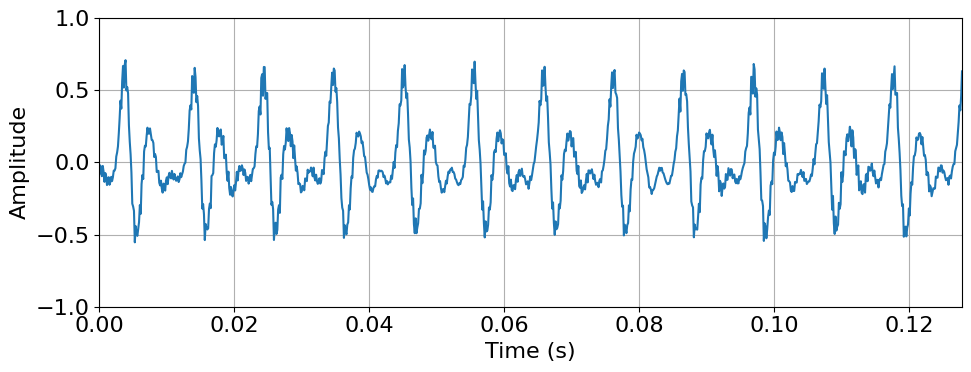

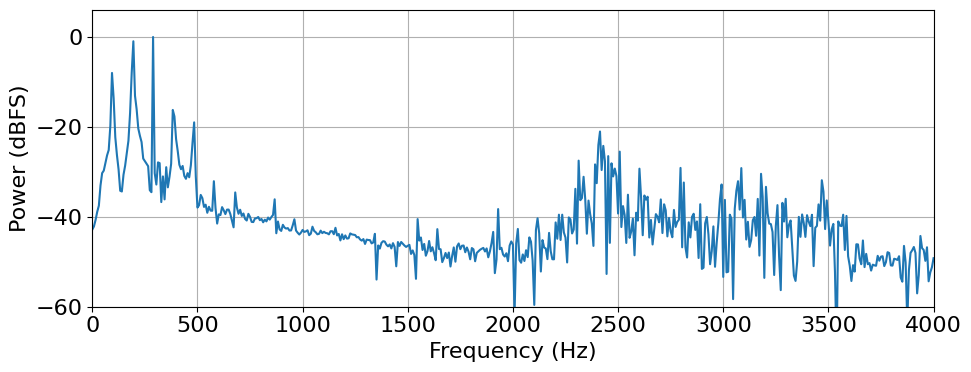

In [37]:
# Plot waveform and spectrum of a frame

y, sr = librosa.load(filename, sr=None)
y = normalize(y)
print(f"Loaded {filename} {len(y)/sr:.2f}s at {sr}Hz")

# frame
L = 1024
idx = int((len(y)/L)//2)         # select frame in the middle
frame = y[idx*L:(idx+1)*L]
print(f"Plotting frame {idx} at {idx*L/sr} s ({int(len(y)/L)} frames)")


fig, ax = plt.subplots(figsize=(10,4))
t = np.arange(0,len(frame))/sr
plot_vs_time(frame, t, fig=(fig,ax))
plt.show()

X, f = dft(frame, sr)
X = normalize(X)
fig, ax = plt.subplots(figsize=(10,4))
plot_vs_freq(X, f, Fs=sr, type="log", fig=(fig,ax), xlim=[0,4000])

ipd.display(ipd.Audio(y, rate=sr))


Pitch: F0: 98 Hz,
Formants: F1: 283 Hz, F2: 1884 Hz, F3: 2462 Hz


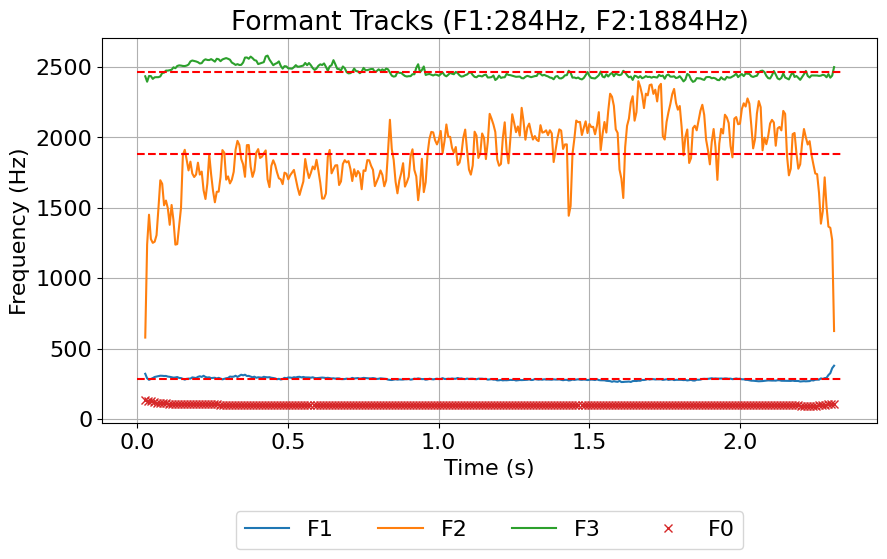

In [42]:
# PRAAT formant and pitch analisys

# Sound object from file
snd = parselmouth.Sound(filename)
xt = snd.xs()      # time axis
x = snd.values[0]  # snd.values is an array, get [0] track

# Pitch object
pitch = snd.to_pitch()
# Get pitch values as a NumPy array
pitch_values = pitch.selected_array['frequency']

# Formant object
formants = snd.to_formant_burg()
formant_times = formants.ts()
formant_values = [
    [formants.get_value_at_time(1, t),
    formants.get_value_at_time(2, t),
    formants.get_value_at_time(3, t)]
    for t in formant_times
]

formant_values = np.array(formant_values)

F0_mean = np.mean(pitch_values)
print(f"Pitch: F0: {int(F0_mean)} Hz,")

F1_mean = np.mean(formant_values[:, 0])
F2_mean = np.mean(formant_values[:, 1])
F3_mean = np.mean(formant_values[:, 2])
formants = [F1_mean, F2_mean, F3_mean]
print(f"Formants: F1: {int(F1_mean)} Hz, F2: {int(F2_mean)} Hz, F3: {int(F3_mean)} Hz")


# Plot the formant tracks
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(formant_times, formant_values[:, 0], label="F1")
plt.plot(formant_times, formant_values[:, 1], label="F2")
plt.plot(formant_times, formant_values[:, 2], label="F3")
plt.plot(pitch.ts(), pitch_values, 'x', label="F0")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Formant Tracks (F1:{F1_mean:.0f}Hz, F2:{F2_mean:.0f}Hz)")
plt.legend(bbox_to_anchor=(0.5, -0.20), loc='upper center', ncol=4)
plt.hlines(formants, xmin=0, xmax=xt[-1], linestyles="dashed", colors="red")
plt.grid(True)
plt.show()



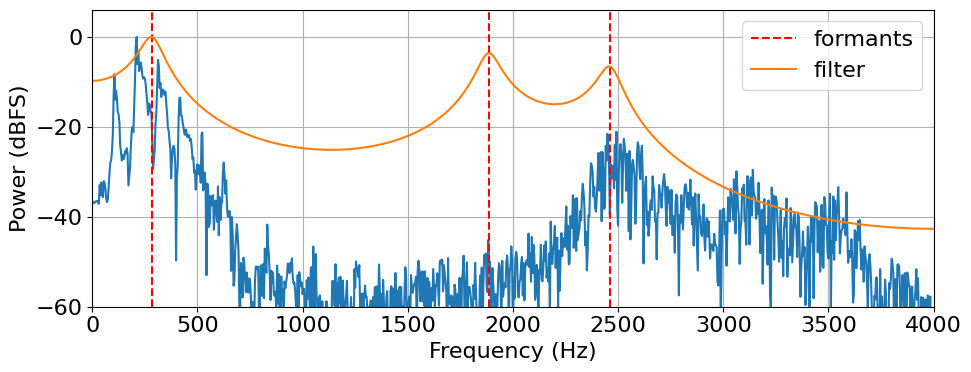

In [39]:
# Formants and filter spectrum

Nfft = 2048
X, f = dft(x, sr, N=Nfft)

b, a = create_formant_filter(formants, sr)
w, H = scipy.signal.freqz(b, a, worN=Nfft)
H = normalize(np.abs(H))
H_dB = 20 * np.log10(H + 1e-12)
f_hz = w/np.pi*(sr/2)

fig, ax = plt.subplots(figsize=(10,4))
plot_vs_freq(normalize(X), f, Fs=sr, type="log", fig=(fig,ax), xlim=[0,4000])
ax.vlines(formants, ymin=-60, ymax=10, linestyles="dashed", colors="red", label="formants")
ax.plot(f_hz, H_dB, label='filter')
plt.legend()

